# StarDist 3D Prediction Jupyter Notebook - TiM2023

In [ ]:
Modified from: https://github.com/stardist/stardist/tree/master/examples/3D

The Jupyter Notebook show how startdist inference can be applied on 3D images. User need to modify the user settinings to 
specify the input raw data direcory and the model directory (see below)


In [2]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from tifffile import imsave

from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D

np.random.seed(6)
lbl_cmap = random_label_cmap()

In [ ]:
# In Case of multiple GPUs choose the GPU to use
gpu = '0'
use_selected_card = gpu
print("StarDist runs on GPU", gpu)

In [3]:
# Prevent OOM Error by setting the max GPU vRAM avaible for tensorflow
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

# Load the raw images and the trained model

In [5]:
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
# $$$$$$$$$$$$$$$$$$$$$$$ User Settings $$$$$$$$$$$$$$$$$$$$$$$$
# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$
# IMPORTANT: raw and masks must have the same file name and be in two different input folders

# 1. User INPUT Settings
dir_raw = "C:/Users/CarloBeretta/Downloads/nuceli_3D/train/images/...*"
file_ext = ".tif"
output_model_path = '"C:/Users/CarloBeretta/Downloads/nuceli_3D/train/images/...*"'
model_name = "stardist"
preview = False

X = sorted(glob(dir_raw + file_ext))
X = list(map(imread,X))
file_name = os.listdir(dir_raw)

n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
#axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [ ]:
# Create the output model and image directory
def create_output_directory(results_dir):
    output_image_path = os.path.join(results_dir,'results_' + str(os.path.basename(os.path.normpath(results_dir))) + '_' + str(datetime.datetime.now()).replace(' ','_').replace('.','p').replace(':','T'))
    if not (os.path.exists(output_model_path) or os.path.exists(output_image_path)):
        os.mkdir(output_image_path)
    return output_image_path

results_dir = os.path.normpath(os.path.dirname(X[0]))
output_image_path = create_output_directory(results_dir)
print('Creatining OUTPUT Images directory in the raw images path:', output_image_path)

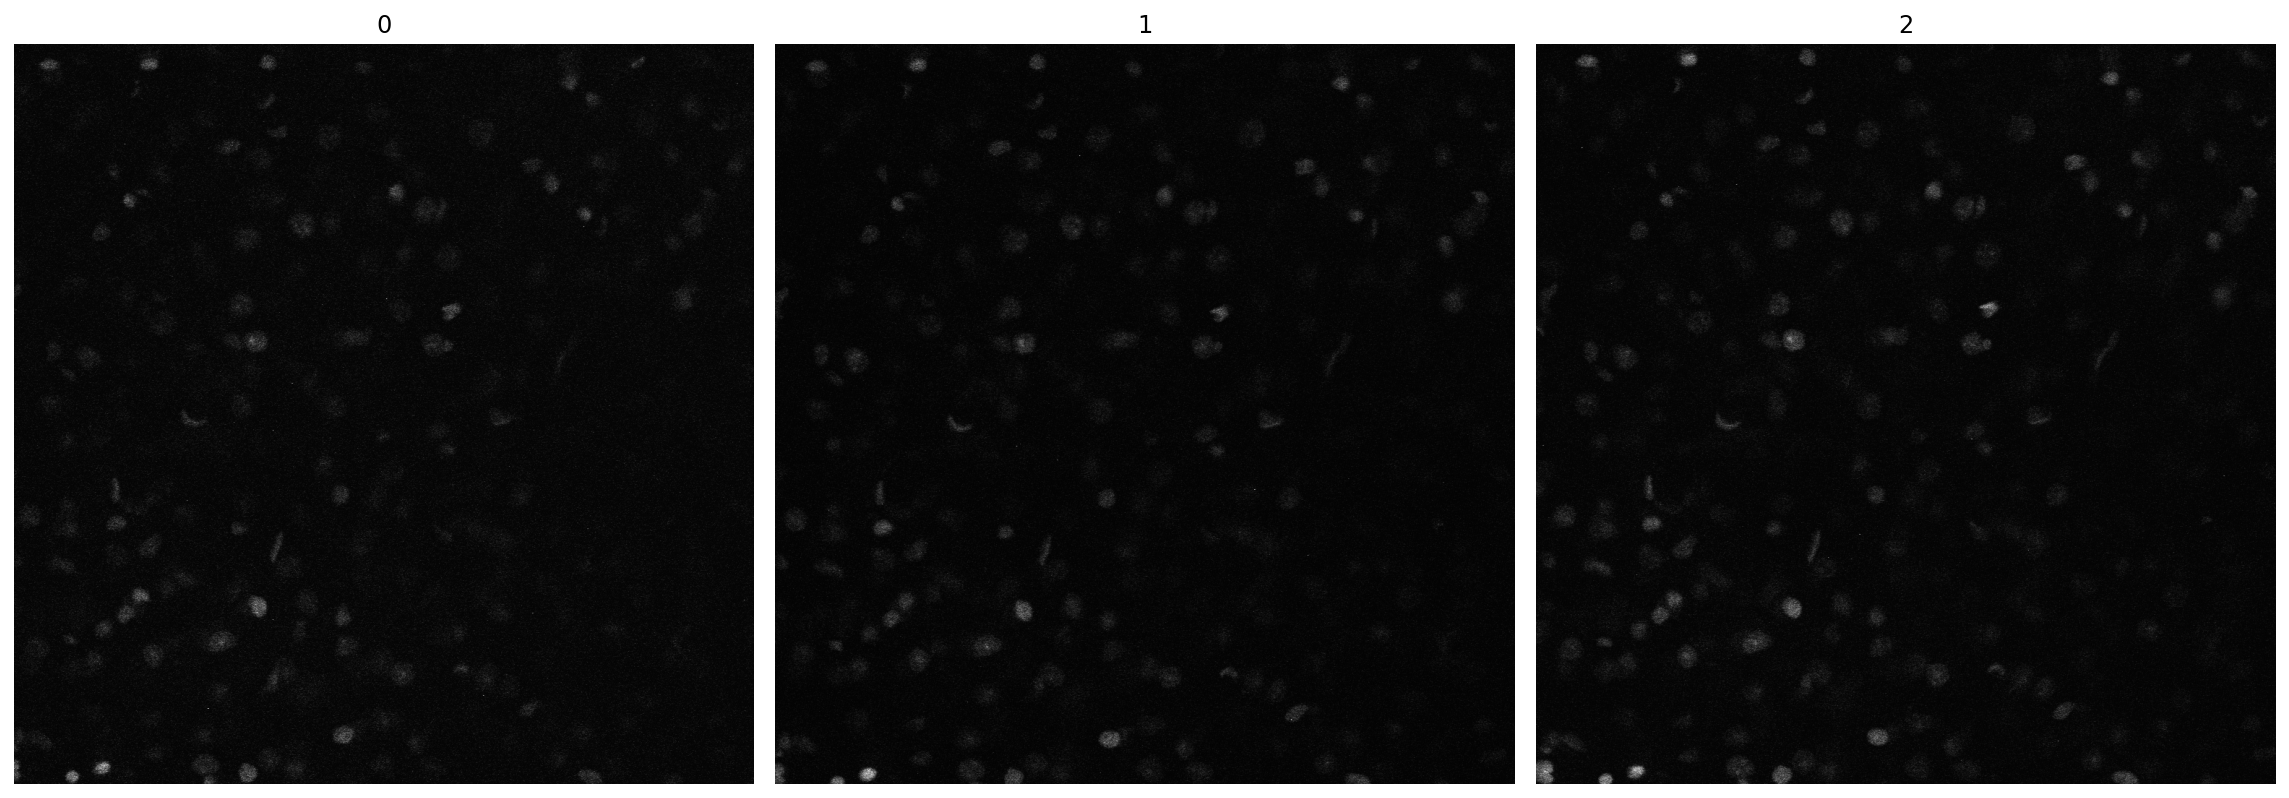

In [6]:
# show all test images
if True:
    fig, ax = plt.subplots(1,3, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x[x.shape[0]//2],cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

In [7]:
model = StarDist3D(None, name=model_name, basedir=output_model_path)

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.582831, nms_thresh=0.3.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [8]:
# Use the first or the last image for normalization X[0] or X[len(X)]
img = normalize(X[0], 1,99.8, axis=axis_norm)

# n_tiles can be increase in case of GPU OOM Erorr (_big)
labels, details = model.predict_instances(img, n_tiles=model._guess_n_tiles(img))

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:33<00:00,  2.43it/s]


In [9]:
print(model._guess_n_tiles(img))

(1, 9, 9)


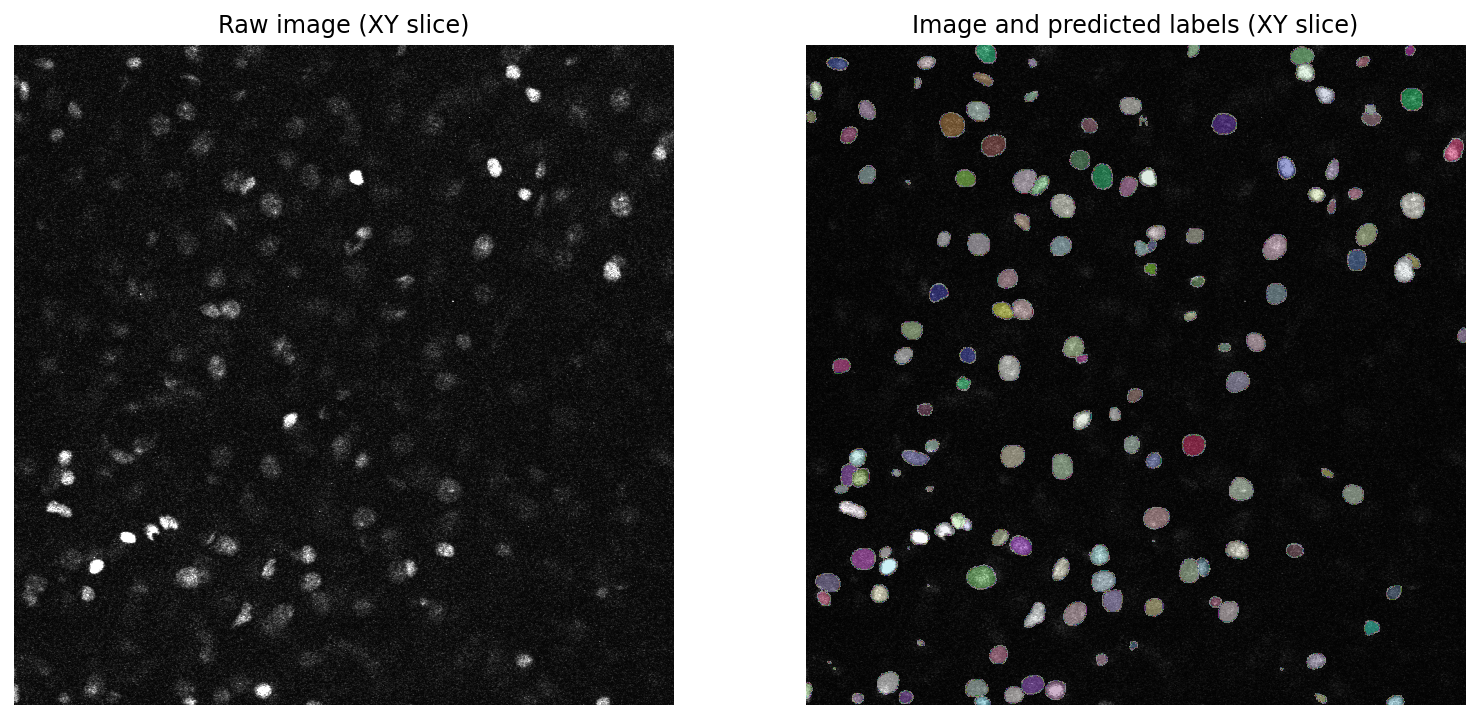

In [10]:
plt.figure(figsize=(13,10))
z = max(0, img.shape[0] // 2 - 5)
plt.subplot(121)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.title('Raw image (XY slice)')
plt.axis('off')
plt.subplot(122)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
plt.title('Image and predicted labels (XY slice)')
plt.axis('off');

# Show results

In [11]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img, n_tiles=model._guess_n_tiles(img))
    
    print(file_name[i])
    plt.figure(figsize=(13,8))
    z = img.shape[0] // 2
    y = img.shape[1] // 2
    img_show = img if img.ndim==3 else img[...,:3]    
    plt.subplot(221); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.subplot(222); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.subplot(223); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
    plt.subplot(224); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.imshow(labels[:,y], cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

In [12]:
# Plot the prediction of each processed file. This step is not necessary and it can make the process slower!
preview = preview

if preview: 
    for i in range(len(X)):
        example(model, i)  
else:
    print("Preview skipped!")
None;

Preview skipped!


# Save masks

Processing: G:/Sofiya/2022-06-22/output/220621_anaest1_15-32-37.tif


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:33<00:00,  2.42it/s]


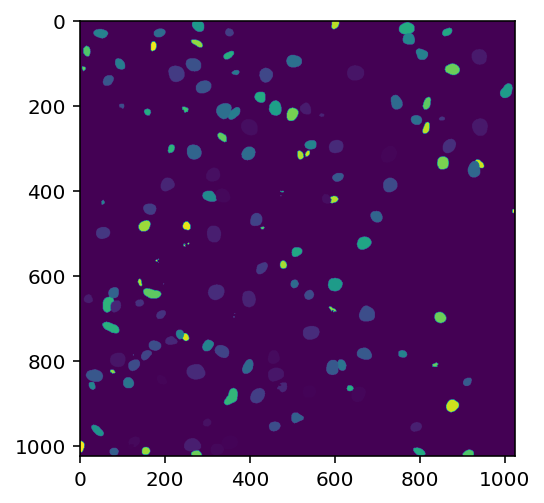

169861043.py (11): <tifffile.imsave> is deprecated. Use tifffile.imwrite


Processing: G:/Sofiya/2022-06-22/output/220621_anaest2_16-05-24.tif


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.20it/s]


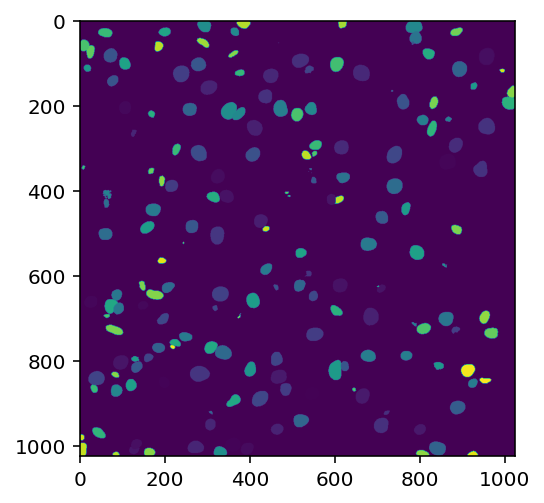

Processing: G:/Sofiya/2022-06-22/output/220621_anaest3_16-31-09.tif


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.20it/s]


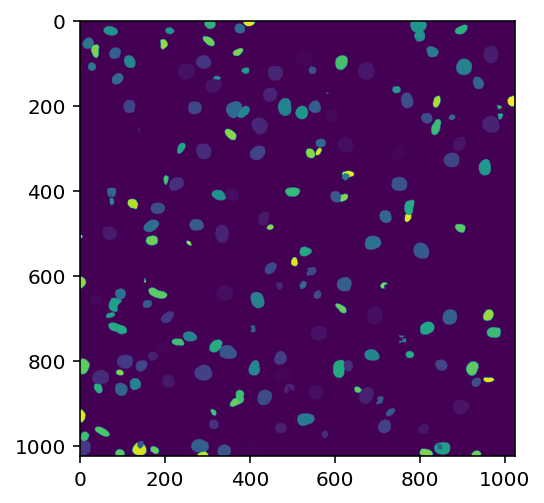

Processing: G:/Sofiya/2022-06-22/output/220621_anaest4_17-01-33.tif


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.19it/s]


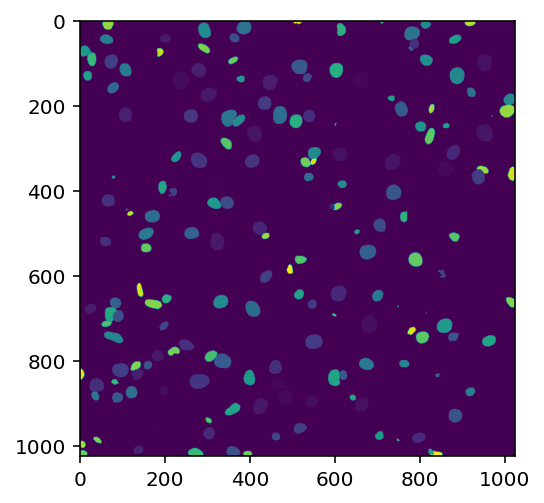

Processing: G:/Sofiya/2022-06-22/output/220621_awake1_14-57-34.tif


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.19it/s]


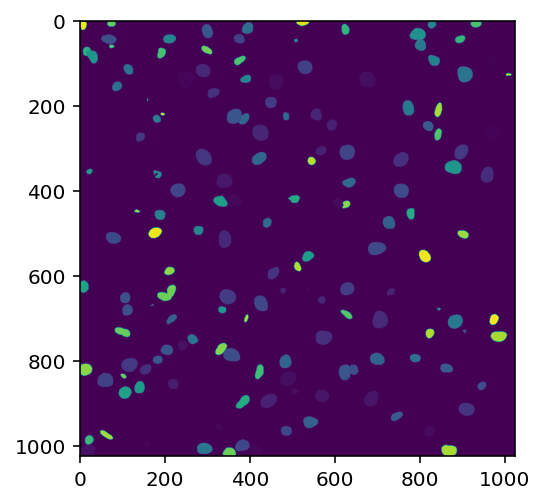

Processing: G:/Sofiya/2022-06-22/output/220621_awake2_15-25-12.tif


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.19it/s]


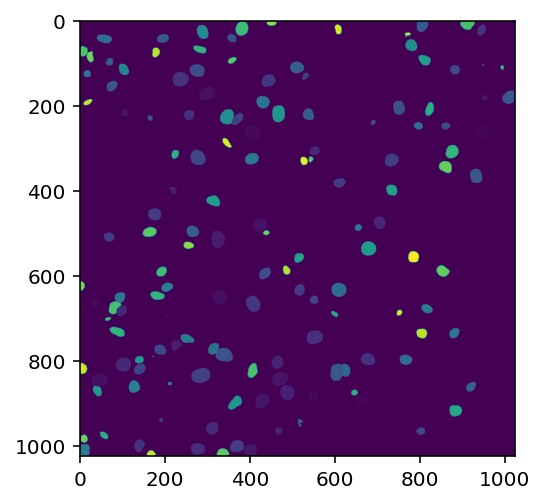

Processing: G:/Sofiya/2022-06-22/output/220621_inject1_17-16-51.tif


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:39<00:00,  2.06it/s]


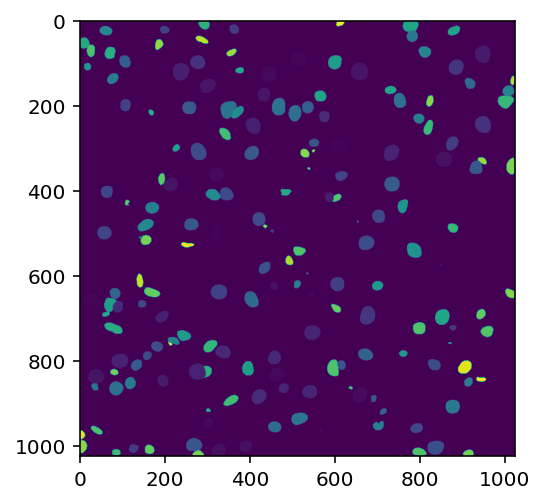

Processing: G:/Sofiya/2022-06-22/output/220621_inject2_17-41-44.tif


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:36<00:00,  2.21it/s]


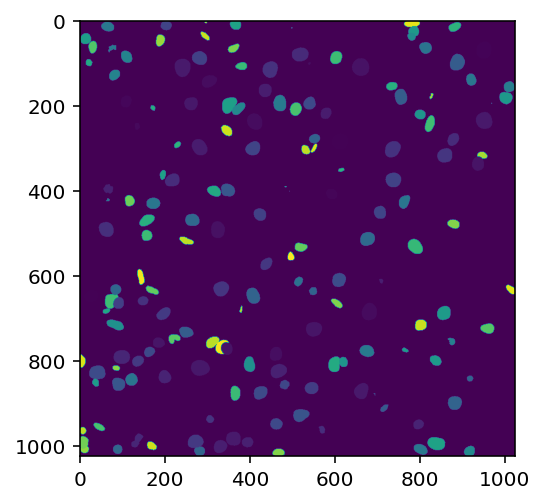

Processing: G:/Sofiya/2022-06-22/output/220621_inject3_18-07-09.tif


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:37<00:00,  2.18it/s]


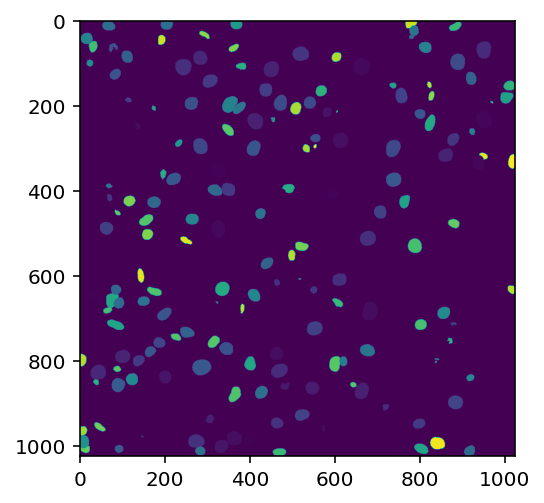

'\nfor f in range(len(X)):\n    img = normalize(X[f], 1,99.8, axis=axis_norm)\n    labels, details = model.predict_instances(img, n_tiles=model._guess_n_tiles(img))\n    imsave(os.path.join(results_dir, file_name[f]), labels)\n    print(os.path.join(results_dir, file_name[f]))\n'

In [13]:
# Save the label stack in the output directory
fnames = [output_image_path+Path(f).name for f in sorted(glob(dir_raw + file_ext))]

for x,f in zip(X,fnames):
    print('Processing:', f)
    x = normalize(x, 1,99.8, axis=axis_norm)
    labeled_image, description = model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=True)
    plt.imshow(labeled_image[10])
    plt.show()
    imsave(f,labeled_image)